<a href="https://colab.research.google.com/github/pleask/sLIME/blob/main/tutorials/generated_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training transformers for generated datasets
In the previous tutorial we programmatically generated perturbed instances using the [sLIME-shapes](https://github.com/pleask/slime-shapes) package. In this tutorial we will continue to use that package, but train transfomers as though we cannot directly perturb the examples. Instead we will use pairs of examples, one containing the feature of interest, and the other not containing the feature of interest (but otherwise being identical).

Again, this is not particularly realistic; the real world corollarly might be taking a photo of somebody and then asking them to remove their hat. However, it sets us up for the final tutorial, in which we train transformers without the use of the example with the feature removed.

In the last tutorial we fixed the reliance of our classification model on the background colour, so in this tutorial we will only consider whether the background colour deviates from a base colour (we will arbitrarily use purple) to simplify things.

In [50]:
%%capture
!pip install git+https://github.com/pleask/sLIME.git
!pip install git+https://github.com/pleask/slime-shapes.git

In [51]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from slime_shapes import shapes
import numpy as np
from tensorflow import stack
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Sequential
from tensorflow.keras.losses import MeanSquaredLogarithmicError

@dataclass
class Class:
  class_id: int
  name: str
  shapes: list

CANVAS_SIZE = 32

class ShapeImages(Sequence, ABC):
  def __init__(self, classes, size, batch_size, canvas_size=CANVAS_SIZE):
    self._classes = classes
    self._batch_size = batch_size
    self._size = size
    self._canvas_size = canvas_size

  def __len__(self):
    return self._size // self._batch_size

  def __getitem__(self, idx):
    xs, ys = [], []
    for _ in range(self._batch_size // len(self._classes)):
      for c in self._classes:
        x, y, = self._generate_instance(c)
        xs.append(x)
        ys.append(y)
    return stack(xs), stack(ys)

  @abstractmethod
  def _generate_instance(self, c):
    pass

get_random_colour = lambda: np.random.randint(0, 255, size=(3))

class ShapeRemovalDataset(ShapeImages):
  def __init__(self, *args, shape_to_remove=None, **kwargs):
    self._shape_to_remove = shape_to_remove
    super().__init__(*args, **kwargs)

  def _generate_instance(self, c):
    positions = shapes.get_positions(self._canvas_size, len(c.shapes), min_ratio=0.25, max_ratio=0.375)
    x_canvas = shapes.Square(positions[0], colour=get_random_colour()).create_canvas()
    y_canvas = np.copy(x_canvas)
    for i, shape_class in enumerate(c.shapes):
      shape = shape_class(positions[i+1], colour=shapes.BLUE)
      shape.add_to_image(x_canvas)
      if shape_class != self._shape_to_remove:
        shape.add_to_image(y_canvas)
    return x_canvas / 255.0, y_canvas / 255.0

class BackgroundRemovalDataset(ShapeImages):
  def __init__(self, *args, shape_to_remove=None, **kwargs):
    super().__init__(*args, **kwargs)

  def _generate_instance(self, c):
    positions = shapes.get_positions(self._canvas_size, len(c.shapes), min_ratio=0.25, max_ratio=0.375)
    x_canvas = shapes.Square(positions[0], colour=get_random_colour()).create_canvas()
    y_canvas = shapes.Square(positions[0], colour=shapes.PURPLE).create_canvas()
    for i, shape_class in enumerate(c.shapes):
      shape = shape_class(positions[i+1], colour=shapes.BLUE)
      shape.add_to_image(x_canvas)
      shape.add_to_image(y_canvas)
    return x_canvas / 255.0, y_canvas / 255.0

random_background_classes = [
  Class(0, 'none', []),
  Class(1, 'circle', [shapes.Circle]),
  Class(2, 'square', [shapes.Square]),
  Class(3, 'both', [shapes.Circle, shapes.Square]),
]

def get_transformer(dataset_size=300000, shape_to_remove=None, dataset=ShapeRemovalDataset):
  base_count = 32
  
  transformer = Sequential([
    layers.Input(shape=(CANVAS_SIZE, CANVAS_SIZE, 3)),
    layers.Conv2D(base_count, 11, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding="same"),
    layers.Conv2D(base_count * 4, 5, padding='same', activation='relu'),
    layers.Conv2DTranspose(100, 3, strides=2, activation="relu", padding="same"),
    layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same"),
  ])

  transformer.compile(optimizer='adam', loss=MeanSquaredLogarithmicError())

  epochs=1
  history = transformer.fit(
    dataset(random_background_classes, dataset_size, 32, shape_to_remove=shape_to_remove, canvas_size=CANVAS_SIZE),
    validation_data=dataset(random_background_classes, dataset_size//4, 32, shape_to_remove=shape_to_remove, canvas_size=CANVAS_SIZE),
    epochs=epochs
  )

  return transformer

circle_transformer = get_transformer(shape_to_remove=shapes.Circle)
square_transformer = get_transformer(shape_to_remove=shapes.Square)
background_transformer = get_transformer(dataset=BackgroundRemovalDataset)

9375/9375 [==============================] - 899s 96ms/step - loss: 8.0051e-05 - val_loss: 9.2816e-06


We also train the same classifier we used in the last tutorial.

In [52]:
from typing import Union, Callable
from tensorflow.keras.losses import SparseCategoricalCrossentropy

@dataclass
class ShapesClass:
  class_id: int
  name: str
  shapes: list

class ShapeClassificationDataset(Sequence):
  """
  Dataset of shapes images and their classes. A list of ShapesClass objects is
  used to specify which classes to generate (particularly their background).
  """
  def __init__(self, classes, size, batch_size, canvas_size=CANVAS_SIZE):
    self._classes = classes
    self._batch_size = batch_size
    self._size = size
    self._canvas_size = canvas_size

  def __len__(self):
    return self._size // self._batch_size

  def __getitem__(self, idx):
    """
    Gets the idx-th batch of examples. Reproducibility is ignored here for
    brevity, each batch consists of random examples.
    """
    xs, ys = [], []
    for _ in range(self._batch_size // len(self._classes)):
      for c in self._classes:
        x, y, = self._generate_instance(c)
        xs.append(x)
        ys.append(y)
    return stack(xs), stack(ys)
  
  def _generate_instance(self, c):
    positions = shapes.get_positions(self._canvas_size, len(c.shapes), min_ratio=0.25, max_ratio=0.375)
    background_colour = get_random_colour()
    canvas = shapes.Square(positions[0], colour=background_colour).create_canvas()
    for i, shape in enumerate(c.shapes):
      shape(positions[i+1], colour=shapes.BLUE).add_to_image(canvas)
    return canvas / 255.0, c.class_id

def get_shape_classifier(background_classes):
  num_classes = len(background_classes)

  model = Sequential([
    layers.Conv2D(4, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
    layers.Softmax()
  ])

  model.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  epochs=3
  history = model.fit(
    ShapeClassificationDataset(background_classes, 100000, 32),
    validation_data=ShapeClassificationDataset(background_classes, 10000, 32),
    epochs=epochs
  )

  return model

random_background_classes = [
  Class(0, 'none', []),
  Class(1, 'circle', [shapes.Circle]),
  Class(2, 'square', [shapes.Square]),
  Class(3, 'both', [shapes.Circle, shapes.Square]),
]

fixed_shape_classifier = get_shape_classifier(random_background_classes)

Epoch 1/3
3125/3125 [==============================] - 153s 49ms/step - loss: 0.8636 - accuracy: 0.8786 - val_loss: 0.7770 - val_accuracy: 0.9683
Epoch 2/3
3125/3125 [==============================] - 139s 45ms/step - loss: 0.7765 - accuracy: 0.9668 - val_loss: 0.7749 - val_accuracy: 0.9679
Epoch 3/3
3125/3125 [==============================] - 141s 45ms/step - loss: 0.7707 - accuracy: 0.9727 - val_loss: 0.7633 - val_accuracy: 0.9805


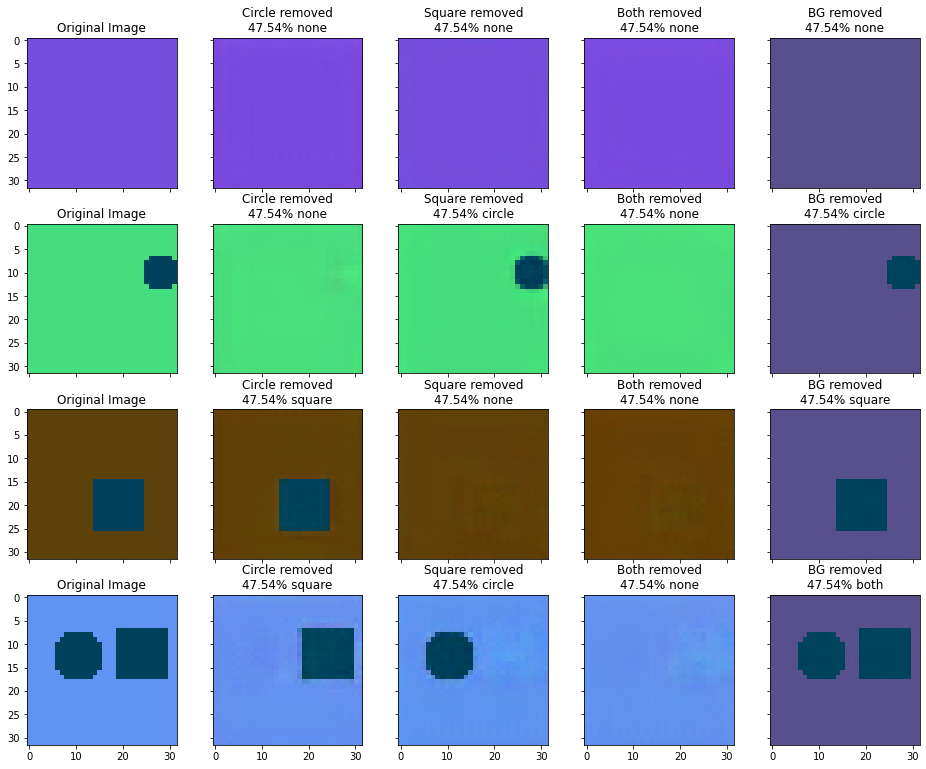

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.nn import softmax 

@dataclass
class TitledImage:
  title: str
  img: np.ndarray

def show_transformed_class_predictions(model):
  batch = ShapeRemovalDataset(random_background_classes, 4, 4, shape_to_remove=shapes.Square, canvas_size=CANVAS_SIZE)[0]
  images = []
  for i in range(4):
    x = batch[0][i]
    predict_batch = stack([x])
    circle_removed = circle_transformer.predict(predict_batch)
    square_removed = square_transformer.predict(predict_batch)
    both_removed = square_transformer.predict(
        circle_transformer.predict(predict_batch)
    )
    background_removed = background_transformer.predict(predict_batch)

    get_class_name = lambda i: random_background_classes[i].name
    def get_class(batch):
      predictions = model.predict(batch)
      scores = softmax(predictions)
      return f'{100*np.max(scores[0]):.2f}% {get_class_name(np.argmax(scores[0]))}'

    images.append(TitledImage('Original Image', x))
    images.append(TitledImage(
      f'Circle removed\n{get_class(circle_removed)}',
      circle_removed[0]
    ))  
    images.append(TitledImage(
      f'Square removed\n{get_class(square_removed)}',
      square_removed[0]
    ))
    images.append(TitledImage(
      f'Both removed\n{get_class(both_removed)}',
      both_removed[0]
    ))
    images.append(TitledImage(
      f'BG removed\n{get_class(background_removed)}',
      background_removed[0]
    ))  

  fig = plt.figure(figsize=(16., 16.))
  grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.5)
  for ax, im in zip(grid, images):
    ax.imshow(im.img)
    ax.set_title(im.title)

show_transformed_class_predictions(fixed_shape_classifier)

Now that we have trained these transformers, we can use LIME to explain classifications from this dataset without having to generate new images with features removed. As before, we expect the shapes to be important, whilst the random colouring of the background should contribute nothing to the explanation.

  0%|          | 0/1000 [00:00<?, ?it/s]

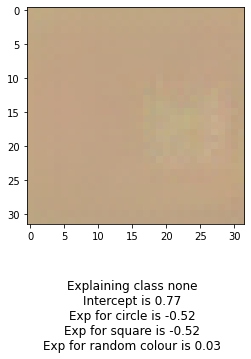

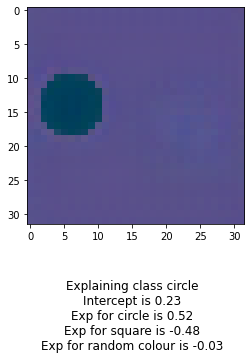

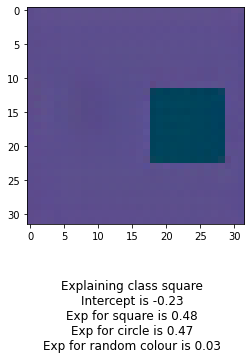

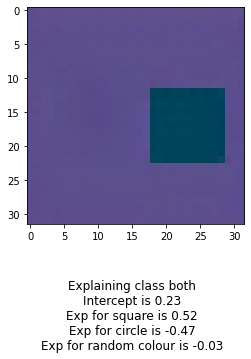

In [56]:
from slime.explain import Explainer 
from slime.transform import Transformer, BinaryPerturber
from sklearn.metrics import pairwise_distances

class ModelTransformer(Transformer):
  def __init__(self, model, name):
    self._model = model
    self._name = name

  @property
  def name(self):
    return self._name

  def transform(self, instance):
    batch = stack([instance])
    return self._model.predict(batch)[0]

def feature_to_readable(i):
  return {
      0: 'random colour', 
      1: 'circle', 
      2: 'square', 
  }[i]

class TransformerPerturber(BinaryPerturber):
    """
    Applies transformations to an instance in order to perturb it.
    """
    def __init__(self, instance, transformers):
        self._instance = instance
        self._transformers = transformers

    def perturb(self, enabled_features):
        instance_copy = np.copy(self._instance)
        for enabled, transformer in zip(enabled_features, self._transformers):
            if not enabled:
                instance_copy = transformer.transform(instance_copy)
        return instance_copy

    @property
    def feature_count(self):
        return len(self._transformers)

instance = ShapeRemovalDataset(random_background_classes, 4, 4, shape_to_remove=shapes.Square, canvas_size=CANVAS_SIZE)[0][0][3]
perturber = TransformerPerturber(instance, [
  ModelTransformer(background_transformer, 'random background'),
  ModelTransformer(circle_transformer, 'circle'),
  ModelTransformer(square_transformer, 'square'),
])

def metric(baseline, prediction):
  return pairwise_distances(
      [prediction],
      baseline.reshape(1, -1),
      metric='cosine'
  ).ravel()

def print_explanation(feature_to_readable, explanation):
  classes_to_explain = list(explanation.local_exp.keys())
  explanations = [explanation.explain(c, num_features=1) for c in classes_to_explain]
  
  for i, c in enumerate(classes_to_explain):
    figtext_lines = [
      f'Explaining class {random_background_classes[i].name}',
      f'Intercept is {explanation.intercept[c]:.2f}'
    ]
    for exp in explanation.local_exp[c]:
      figtext_lines.append(f'Exp for {feature_to_readable(exp[0])} is {exp[1]:.2f}')
    plt.figure(figsize=(4., 4.))
    plt.imshow(explanations[i])
    plt.figtext(0.5, -0.30, 
      '\n'.join(figtext_lines), 
      wrap=True, horizontalalignment='center', fontsize=12
    )

explainer = Explainer(metric, kernel_width=2.0, random_state=5)
explanation = explainer.explain_instance(perturber, fixed_shape_classifier.predict, top_labels=20, num_features=100, num_samples=1000)
print_explanation(feature_to_readable, explanation)